In [99]:
import cv2
import matplotlib.pyplot as plt

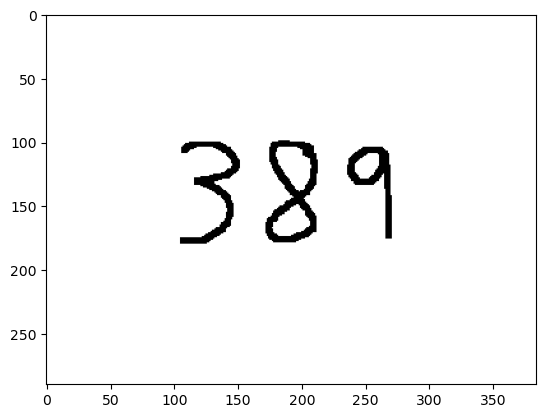

In [100]:
sample = cv2.imread("data/digits/389.png")
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(sample, 125, 255, cv2.THRESH_BINARY_INV)
plt.imshow(sample, cmap="gray")

In [101]:
# dilation parameter; bigger tuple = smaller rectangle
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 1))

# apply dilation to the thresholded monochrome image
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

# find contours and rectangles
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

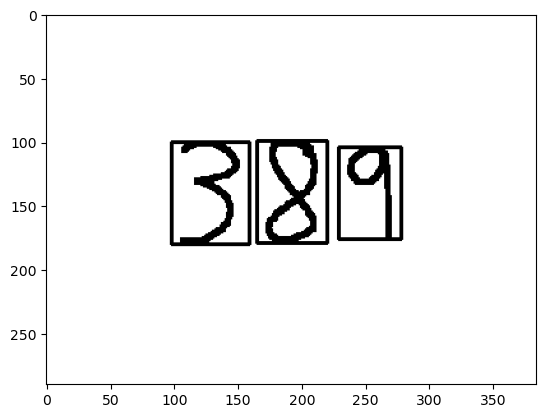

In [102]:
copy = sample.copy()

crops = []
for cnt in contours:
    # get coordinates of contours
    x, y, w, h = cv2.boundingRect(cnt)

    # draw rectangle for each contour
    cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # create crops per contour
    crop = thresh[y:y+h, x:x+w]
    crops.append(crop)

plt.imshow(copy, cmap="gray")

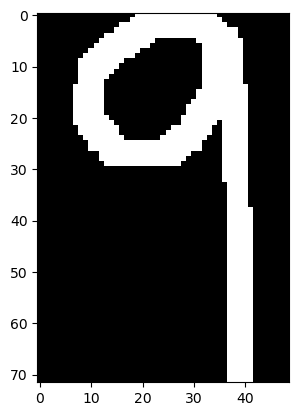

In [107]:
single = crops[0]
plt.imshow(single, cmap="gray")

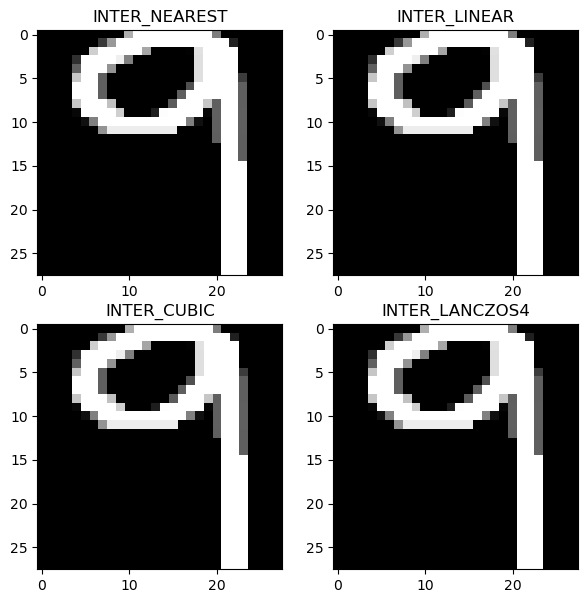

In [113]:
# see different interpolations of resizing crop
plt.figure(figsize=(7, 7))

plt.subplot(221);
resized_single = cv2.resize(single, (28, 28), cv2.INTER_NEAREST)
plt.title("INTER_NEAREST")
plt.imshow(resized_single, cmap="gray")

plt.subplot(222)
resized_single = cv2.resize(single, (28, 28), cv2.INTER_LINEAR)
plt.title("INTER_LINEAR")
plt.imshow(resized_single, cmap="gray")

plt.subplot(223)
resized_single = cv2.resize(single, (28, 28), cv2.INTER_CUBIC)
plt.title("INTER_CUBIC")
plt.imshow(resized_single, cmap="gray")

plt.subplot(224)
resized_single = cv2.resize(single, (28, 28), cv2.INTER_LANCZOS4)
plt.title("INTER_LANCZOS4")
plt.imshow(resized_single, cmap="gray")

About the same. Using default should be good already